## Importation des packages et bases de données

In [1]:
import pandas as pd
import numpy.random as np
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#Importation des bases de données
IBP = pd.read_excel(r'C:\Users\Hugo\Desktop\Stat App\IBP.xlsx')
Ref = pd.read_excel(r'C:\Users\Hugo\Desktop\Stat App\Ref.xlsx')
CCY = pd.read_excel(r'C:\Users\Hugo\Desktop\Stat App\CCY.xlsx')
FOEPS=pd.read_excel(r'C:\Users\Hugo\Desktop\Stat App\FOEPS.xlsx')
FOSAL=pd.read_excel(r'C:\Users\Hugo\Desktop\Stat App\F0SAL.xlsx')
IBNOSH=pd.read_excel(r'C:\Users\Hugo\Desktop\Stat App\IBNOSH.xlsx')

#IBP = pd.read_excel("C:\Users\Fanny\Python\Statapp\Donnees statapp\IBP.xlsx", sep="\t", encoding="utf-8")
#Ref = pd.read_excel('C:\Users\Fanny\Python\Statapp\Donnees statapp\Ref.xlsx', sep="\t", encoding="utf-8")
#IBNOSH = pd.read_excel('C:\Users\Fanny\Python\Statapp\Donnees statapp\IBNOSH.xlsx', sep="\t", encoding="utf-8")
#FOEPS = pd.read_excel('C:\Users\Fanny\Python\Statapp\Donnees statapp\FOEPS.xlsx', sep="\t", encoding="utf-8")
#CCY = pd.read_excel('C:\Users\Fanny\Python\Statapp\Donnees statapp\CCY.xlsx', sep="\t", encoding="utf-8")
#FOSAL = pd.read_excel("C:\Users\Fanny\Python\Statapp\Donnees statapp\FOSAL.xlsx", sep="\t", encoding="utf-8")


In [10]:
#On change les noms des variables dans les bases pour S'assurer que les noms soient uniformisés ; on utilise la var Name dans Ref
#car elle fait fonction d'identifiant ; voir si plus tard on utilise plutôt DSCD
bases = [IBP, IBNOSH, FOEPS, FOSAL]
def change_name(base):
    variable_base=['Date']
    for i in range(len(IBP.columns)-1) :
        variable_base.append(Ref['NAME'][i])
    variable_id=['Date']         #on vérifie si les entreprises correspondent à partir de l'id (DSCD)
    for i in range(len(base.columns)-1) :
        variable_id.append(Ref['Type'][i])   
    if base.loc[0].tolist()[1:]==variable_id[1:] : #donne tous éléments à partir de l'indice 1 de la liste = à la 1e observation de la base
        base.columns=variable_base
    else :
        print("les id ne correspondent pas")


for i in bases:
    change_name(i)

## Dictionnaires permettant d'accéder à des sous populations

In [11]:
#On crée les listes qui nous permettent de faire le dico entreprises
# On cherche à isoler les sociétés par pays

liste_pays=np.unique(Ref["GEOGRAPHIC DESCR."]) #liste des pays par ordre alphabétique

#Liste des entreprises
liste_entreprises=np.unique(Ref['NAME'])
societes_avec_secteur=Ref.dropna(axis=0, how='any') #On enlève toutes les entreprises où une information sur les secteurs est manquante

#On regarde tous les secteurs d'activités différents au niveau 5
liste_secteurs_5=np.unique(societes_avec_secteur["LEVEL5 SECTOR NAME"])
#Il n'y a que deux types d'activités, sociétés agricoles et sociétés de l'industrie agroalimentaire

In [12]:
#On crée un dictionnaire unique qui pour un pays, un secteur ou les deux, ou le nom de l'entreprise
#donne le subset de Ref des entreprises correspondantes

#initialisation du dico
entreprises={ 'Agricole' : societes_avec_secteur[societes_avec_secteur["LEVEL5 SECTOR NAME"]=='Farm Fish Plantation'],
    'Agroalimentaire' : societes_avec_secteur[societes_avec_secteur["LEVEL5 SECTOR NAME"]=='Food Products']    
}
#on le remplit
for i in liste_pays :
    entreprises[i]=Ref[Ref["GEOGRAPHIC DESCR."]==i] #on ne garde que les entreprises localisées dans le pays i
    
for i in ['Agricole', 'Agroalimentaire'] : #on boucle sur tous les secteurs
    for j in liste_pays : #on boucle sur tous les pays de la base
        entreprises[i,j]=entreprises[i][entreprises[i]["GEOGRAPHIC DESCR."]==j]
        #dans les entreprises du secteur i on ne garde que celles dont la localisation est j
        
for j in liste_pays :
    for i in ['Agricole', 'Agroalimentaire'] :
        entreprises[j,i]=entreprises[i][entreprises[i]["GEOGRAPHIC DESCR."]==j]
        
for i in liste_entreprises :
    entreprises[i]=Ref[Ref['NAME']==i]
        
#Le dictionnaire est opérationnel


In [14]:
#On crée une fonction qui va créer un dico pour chaque base qui va associer à chaque pays, secteur ou les deux 
#les cours boursiers, earnings, ventes ou nbr d'actions des entreprises de ce pays/secteur d'activité
#en fonction de la base mise en argument dans la fonction 

def dico(base):  #on met en entrée une des bases (IBP, IBNOSH, FOEPS ou FOSAL)
    dico={}
    for i in liste_pays : 
        l=entreprises[i]["NAME"].tolist() #on récupère la liste des entreprises dans le pays i
    #la fonction tolist() permet de transformer une série temporelle en une liste
        l.insert(0,"Date") #on y ajoute au début la variable date
        dico[i] = base[l] #on récupère les cours boursiers des entreprises du pays i   
    for i in ['Agricole', 'Agroalimentaire'] : #on boucle sur tous les secteurs
        l=entreprises[i]["NAME"].tolist()
        l.insert(0,"Date")
        dico[i]=base[l]
        for j in liste_pays : #on boucle sur tous les pays de la base
            l=entreprises[i,j]["NAME"].tolist() #on récupère la liste des entreprises dans le pays i
            #la fonction tolist() permet de transformer une série temporelle en une liste
            l.insert(0,"Date") #on y ajoute au début la variable date
            dico[i,j]=base[l]
            #dans les entreprises du secteur i on ne garde que celles dont la localisation est j
    for j in liste_pays :
        for i in ['Agricole', 'Agroalimentaire'] :
            l=entreprises[i,j]["NAME"].tolist() #on récupère la liste des entreprises dans le pays i
            #la fonction tolist() permet de transformer une série temporelle en une liste
            l.insert(0,"Date") #on y ajoute au début la variable date
            dico[j,i]=base[l]
            #dans les entreprises du secteur i on ne garde que celles dont la localisation est j
    for i in liste_entreprises :
        dico[i]=base[['Date',i]]
    return dico

#On crée et renomme les 4 dico par des noms plus intuitifs : 
cours_boursiers = dico(IBP)
earnings = dico(FOEPS)
nbr_actions = dico(IBNOSH)
ventes = dico(FOSAL)

In [137]:
#Dans chaque séries de cours boursiers on va enlever les dates pour lesquelles globalement on n'a aucune valeur
#for k in cours_boursiers :
#    cours_boursiers[k]=cours_boursiers[k].dropna(axis=0,thresh=2) #comme on a la donnée date il faut s'assurer d'avoir une donnée en plus

#Dernières lignes inutiles car on a fait une nouvelle fonction


## Fonction ne conservant que les cours significatifs

In [17]:
#On crée une fonction qui prendra en argument un tableau de cotation et une durée d'observations n en années : 

def troncature(cotations,n) :
    t=cotations
    for i in range(1,len(cotations.columns)) :
        k=0
        l=cotations[cotations.columns[i]].values.tolist() #on convertit en liste les valeurs prises par la variable IBP.columns[]
        for j in range(len(l)) :
            if l[j] == l[j] : #on regarde si la valeur n'est pas nan
                k+=1
        if k<(n*12) : #si on a moins de n observations on enlève la colonne
            t=t.drop(cotations.columns[i],axis=1)
    return(t)
#attention : ne fournit pas n observations successives, mais n observations en tout, quelle que soit leur dispersion dans le temps [Fanny]

In [80]:
#F0EPS on a toujours la première ligne DSCD

FOEPS=FOEPS_tot[1:502]

FOEPS=FOEPS.dropna(axis=1, how='all') #on regarde s'il y a des colonnes vides

#il y en avait une dizaine



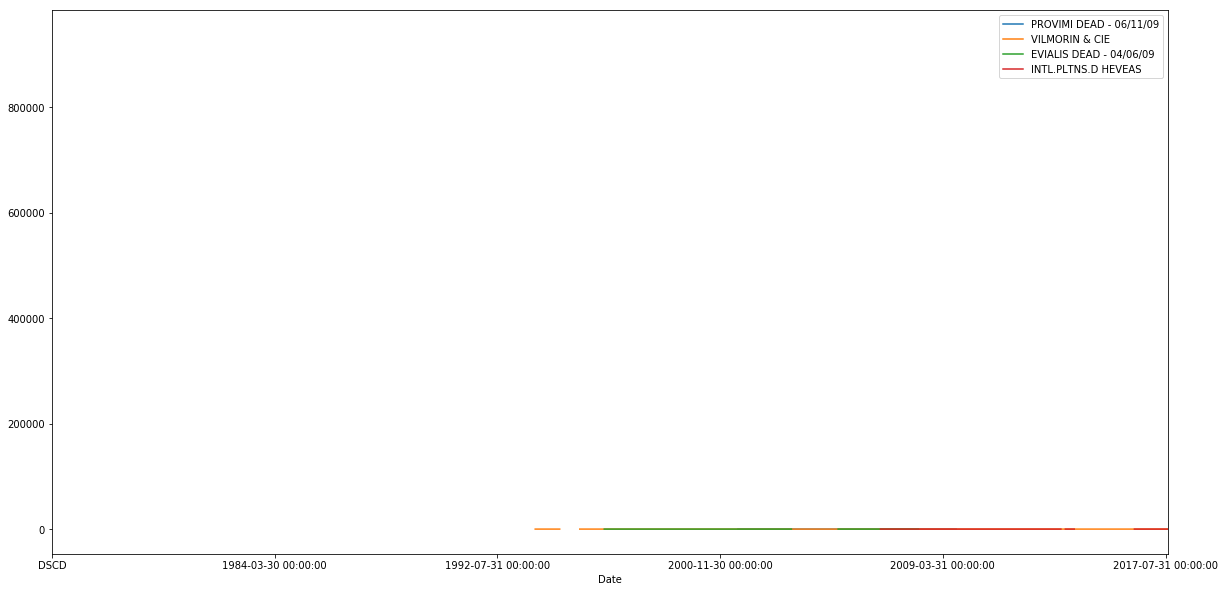

In [18]:
earnings['Agricole','FRANCE'].plot(x='Date',figsize=(20,10))
plt.show()

In [19]:
#Il pourrait être intéressant de mettre en parallèles les revenus et les cours boursiers
#on va essayer de le faire avec une requête SQL
A=cours_boursiers['FRANCE','Agricole']
B=earnings['FRANCE','Agricole']
del B['Date']

test=pd.concat([A,B],join='inner',axis=1)
test

,Date,PROVIMI DEAD - 06/11/09,VILMORIN & CIE,EVIALIS DEAD - 04/06/09,INTL.PLTNS.D HEVEAS,PROVIMI DEAD - 06/11/09,VILMORIN & CIE,EVIALIS DEAD - 04/06/09,INTL.PLTNS.D HEVEAS
0,DSCD,259364.0,309810.00,866679.0,936699.00,259364.0,309810.000,866679.0,936699.00
1,1975-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1976-01-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1976-02-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1976-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1976-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1976-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1976-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1976-07-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1976-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


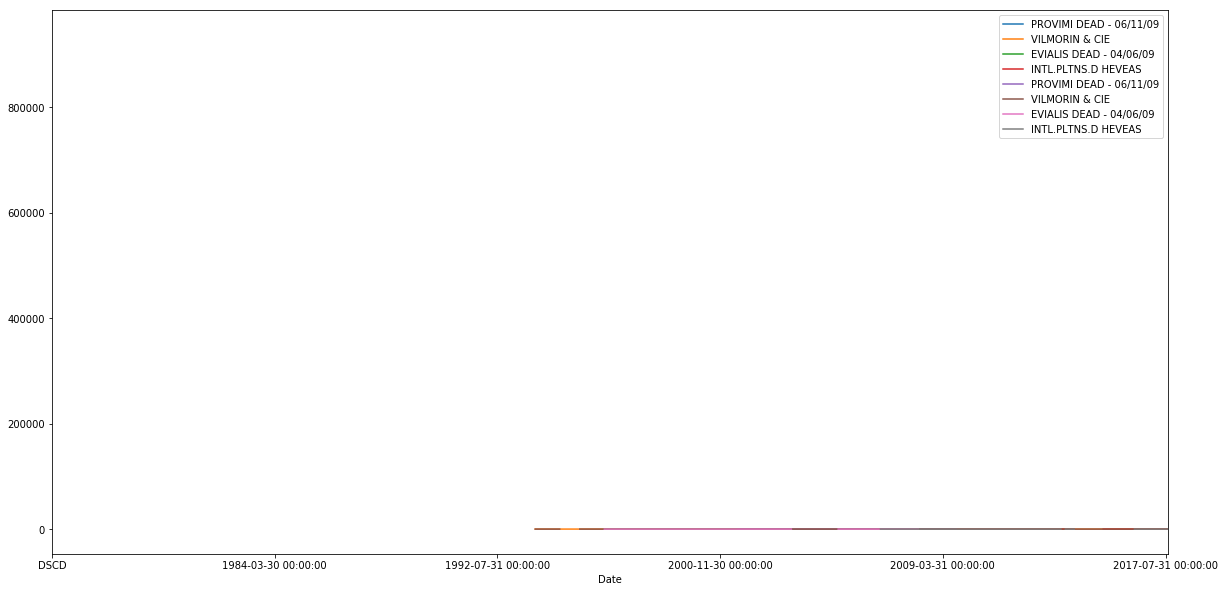

In [20]:
test.plot(x='Date',figsize=(20,10))

plt.show()

## Tracé des graphiques de séries temporelles

In [32]:
#fonction qui a pour argument un dico crée par la fonction dico et une liste d'un ou deux éléments 
#((pays ou secteur ou entreprise) ou (combinaison des deux premiers))
#elle sort un graphique qui représente l'objet du dico (cours boursiers, earnings, ventes ou nbr actions) restreint aux individus 
#indiqués par la liste
def graphique(tableau,liste) : 
    if len(liste)==1 :
        t=tableau[liste[0]][1:] #on enlève la ligne DSCD
        t.plot(x='Date')
        plt.show()
    else :
        t=tableau[liste[0],liste[1]][1:] #on enlève la ligne DSCD
        t.plot(x='Date')
        plt.show()
    

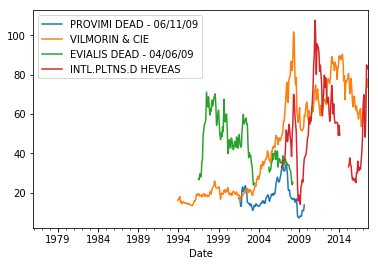

In [33]:
graphique(cours_boursiers,['FRANCE','Agricole'])

## Dico entreprises, séries temp groupées
Nom : entr_st                                           
Clés : entreprises                
Valeurs : dataframes qui ont pour variables cours boursiers, earnings, nbr d'actions en circulation, ventes pour l'entreprise en clé

In [35]:
#On vérifie que les bases IBP, IBNOSH, FOEPS, FOSAL ont les mêmes dates en entrée.
bases = [IBP, IBNOSH, FOEPS, FOSAL]
for i in bases:
    print(len(i))   #elles ont bien toutes la même longueur
dates_ibp = IBP['Date'].tolist() #on crée la liste de dates par base
dates_ibnosh=IBNOSH['Date'].tolist()
dates_foeps=FOEPS['Date'].tolist()
dates_fosal=FOSAL['Date'].tolist()
#on regarde si ces listes sont identiques
if dates_ibp==dates_ibnosh==dates_foeps==dates_fosal:
    print("tout va bien")

502
502
502
502
tout va bien


In [37]:
#Création du dico entr_st
bases = [IBP, IBNOSH, FOEPS, FOSAL]
entr_st = {} #initialisation du dico
A = dico(bases[0])
B = dico(bases[1])
C = dico(bases[2])
D = dico(bases[3])
#on crée le dico avec comme entrée les entreprises et comme valeurs les dataframes voulus
for i in liste_entreprises:
    entr_st[i]=pd.concat([A[i],B[i][B[i].columns[1]],C[i][C[i].columns[1]],D[i][D[i].columns[1]]],join = 'inner',axis=1)
#on garde la colonne date dans la base IBP et on ne prend que la deuxième colonne dans les autres

entr_st['AGRANA BETEILIGUNGS'].columns
#pb : les dataframes ont en colonne 4 fois le nom de l'entreprise : on renomme les colonnes
l=['Date', 'Cours boursiers', 'Nombre actions', 'Earnings', 'Ventes']
for i in liste_entreprises: 
    entr_st[i].columns=l


#on enlève la première ligne qui ne sert plus à rien :
for i in liste_entreprises:
    entr_st[i].drop(0, inplace=True)

entr_st['AGRANA BETEILIGUNGS']

,Date,Cours boursiers,Nombre actions,Earnings,Ventes
1,1975-12-31 00:00:00,NaN,NaN,NaN,NaN
2,1976-01-30 00:00:00,NaN,NaN,NaN,NaN
3,1976-02-27 00:00:00,NaN,NaN,NaN,NaN
4,1976-03-31 00:00:00,NaN,NaN,NaN,NaN
5,1976-04-30 00:00:00,NaN,NaN,NaN,NaN
6,1976-05-31 00:00:00,NaN,NaN,NaN,NaN
7,1976-06-30 00:00:00,NaN,NaN,NaN,NaN
8,1976-07-30 00:00:00,NaN,NaN,NaN,NaN
9,1976-08-31 00:00:00,NaN,NaN,NaN,NaN
10,1976-09-30 00:00:00,NaN,NaN,NaN,NaN


## Calcul de la capitalisation boursière
A partir de ce nouveau dico

In [38]:
#On multiplie cours_boursiers et nbr actions dans chacun des éléments du dico entr_st
#On crée un dico qui a en clé les entreprises et en valeur un df à une colonne qui représente la multiplication de cours boursiers avec nbr actions
cap_bours={}
for i in range (len(liste_entreprises)):
    cap_bours[liste_entreprises[i]]=entr_st[liste_entreprises[i]]['Cours boursiers']*entr_st[liste_entreprises[i]]['Nombre actions']
#je rajoute cette colonne à entr_st
for i in liste_entreprises:
    entr_st[i]=pd.concat([entr_st[i],cap_bours[i]],join = 'inner',axis=1)
#on renomme la colonne ajoutée
for i in liste_entreprises:
    entr_st[i].columns=['Date', 'Cours boursiers', 'Nombre actions', 'Earnings', 'Ventes', 'Capitalisation boursière']
entr_st['AGRANA BETEILIGUNGS']

,Date,Cours boursiers,Nombre actions,Earnings,Ventes,Capitalisation boursière
1,1975-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN
2,1976-01-30 00:00:00,NaN,NaN,NaN,NaN,NaN
3,1976-02-27 00:00:00,NaN,NaN,NaN,NaN,NaN
4,1976-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN
5,1976-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN
6,1976-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN
7,1976-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN
8,1976-07-30 00:00:00,NaN,NaN,NaN,NaN,NaN
9,1976-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN
10,1976-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN


## Dataframe avec la capitalisation boursière de chaque entreprise
sous le format des autres bases

In [39]:
#Je fais un dataframe avec les capitalisations boursières de toutes les entreprises (variables = entr)
CPBR=pd.concat([entr_st[i]['Capitalisation boursière'] for i in liste_entreprises], join = 'inner', axis=1)
#On ajoute la colonne date et on renomme les colonnes
CPBR.columns=liste_entreprises
CPBR=pd.concat([entr_st['ADM HAMBURG']['Date'], CPBR], join='inner', axis=1)
CPBR

,Date,A MOKSEL (XET),A MOKSEL DEAD - 15/08/11,A ZORPAS & SONS DEAD - 01/11/12,A&W BRANDS MERGER,AARHUS UNITED DEAD - T/O BY 31938W,AARHUSKARLSHAMN,AB-BIOTICS,ADECOAGRO,ADM HAMBURG,...,WORTHINGTON FOODS DEAD - MERGER 905922,WT FOODS DEAD - 19/12/01,WYNNSTAY GROUP,YONGYE INTERNATIONAL DEAD - DELIST.08/07/14,YORKS.FOOD GP. DEAD - DELIST 27/02/98,ZAHARNI ZAVODI,ZETAR DEAD - 30/11/12,ZHONGPIN DEAD - DELIST.28/06/13,ZHYTOMYR OIL REFINERY,ZITO DEAD - DELIST.04/03/16
1,1975-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1976-01-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1976-02-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1976-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1976-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1976-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1976-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1976-07-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1976-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1976-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
#on peut appliquer la fonction dico à ce df aussi, qui a le même format que nos bases de données
cap_boursiere=dico(CPBR)
cap_boursiere['FRANCE']

,Date,BEGHIN-SAY DEAD - DELIST 11/08/03,CEREOL DEAD - DELIST 09/04/03,CERESTAR,PROVIMI DEAD - 06/11/09,FLEURY MICHON,VILMORIN & CIE,PAUL PREDAULT DEAD - 01/02/06,PETITJEAN INDS. DEAD - DEL.27/05/98,TIPIAK,...,GRD.MLN.PARIS DEAD - DELISTED,CLAUSE LIMITED DATA,BERGER DEAD - 06/06/95,INTL.PLTNS.D HEVEAS,SAINT-LOUIS DEAD - MERGER 997135,ORTIZ MIKO LIMITED DATA,SAVENCIA,GENERAL BISCUIT DEAD - DEL. 30/12/98,BROSSARD DEAD - 22/07/11,EUROGERM
1,1975-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1976-01-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1976-02-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1976-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1976-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1976-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1976-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1976-07-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1976-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1976-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
